# An Adaptive Bounded-Confidence Model of Opinion Dynamics on Networks

In [17]:
import numpy as np
from numpy.random import default_rng, SeedSequence, RandomState, MT19937
import random
import networkx as nx
from networkx.generators.random_graphs import fast_gnp_random_graph
import pickle
import _pickle as cPickle
import bz2
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
class Node:
    def __init__(self, id, initial_opinion, neighbors=None):
        self.id = id
        self.neighbors = neighbors if neighbors is not None else []
        self.initial_opinion = initial_opinion
        self.current_opinion = initial_opinion
        self.total_opinion_change = 0

    def add_neighbor(self, id):
        self.neighbors.append(id)
    
    def erase_neighbor(self, id):
        self.neighbors.remove(id)

    def check_if_neighbor(self, id):
        return id in self.neighbors
    
    def update_opinion(self, new_x):
        self.total_opinion_change += abs(self.current_opinion - new_x)
        self.current_opinion = new_x
    
    def rewire(self, X, rng):
        # compute rewiring probabilities
        rewiring_prob = self._compute_rewiring_prob(X)
        # pick one from random
        new_neighbor = rng.choice(range(len(rewiring_prob)), p=rewiring_prob)
        # add new neighbor to list of neighbors
        self.add_neighbor(new_neighbor)
        # return the new neighbor so the caller can do housekeeping operations
        return new_neighbor

    
    def _compute_rewiring_prob(self, X):
        # compute distances using the L2 metric
        distances = np.array([(self.current_opinion - x)**2 for x in X])

        # compute the rewiring probability distribution
        rewiring_distr = 1 - distances
        rewiring_distr[self.id] = 0 # set probability for x->x to 0 to prevent self-edge
        rewiring_distr[self.neighbors] = 0 # prevent duplicate edges and length-2 cycles
        # normalize the distribution
        A = np.sum(rewiring_distr)
        rewiring_distr = (1/A) * rewiring_distr 
        
        return rewiring_distr

In [ ]:
class BoundedConfidenceModel:
    def __init__(
            self,
            C,              # confidence bound
            beta,        # rewiring threshold
            trial,      # trial identifer (for saving the model)
            maxsteps=1000000,    # bailout time
            tolerance=0.00001,  # convergence tolerance
            alpha=0.1,      # convergence parameter
            N=1000,              # number of nodes
            p=0.01,              # the p in G(N,p)
            M=1,              # num edges to rewire each step
            K=5,              # num node pairs to adjust opinions each step
            fulltimeseries=False,        # whether or not to save timeseries opinion data
            *, 
            seedseq = None
        ):
        # First, set the random state for this model instance
        # This will ensure exact reproducibility as long as the same seedseq is passed
        self.seedseq = seedseq      # set the SeedSequence just for record
        try:
            self.spawn_key = seedseq.spawn_key[0]
        except:
            self.spawn_key = None

        self.rng = np.random.default_rng(seedseq)
        random.seed(seedseq)
        self.random_state = RandomState(MT19937(seedseq))
        
        self.maxsteps = maxsteps
        self.tolerance = tolerance
        self.alpha = alpha
        self.C = C
        self.beta = beta
        self.N = N
        self.p = p
        self.M = M
        self.K = K
        self.trial = trial
        self.fulltimeseries = fulltimeseries

        self._initialize_system()

        if self.fulltimeseries:
            self.X_data = np.ndarray((self.maxsteps, self.N))
            self.X_data[0, :] = self.X
            self.edge_changes = []
        else:
            self.X_data = np.ndarray((int(self.maxsteps / 500) + 1, self.N))
            self.X_data[0, :] = self.X
            self.G_snapshots = []
        
        self.num_discordant_edges = np.empty(self.maxsteps)      # for keeping track of number of discordant edges
        self.stationary_counter = 0         # for determining if we've reached stationary state
        self.stationary_marker = 0          # for flagging stationary state
        self.convergence_time = None        # for recording convergence time

        # If beta=1, no rewiring will be done
        self.rewiring_enabled = False if int(beta==1) else True

    def run(self):
        t=0

        #======== INNER HELPER FUNCTIONS TO RUN THE MODEL ========
        def rewire_step():
            # compute discordant edges
            discordant_edges = [(i,j) for (i,j) in self.edges if abs(self.X[i] - self.X[j]) > self.beta]
            self.num_discordant_edges[t] = len(discordant_edges)

            # if len(discordant_edges) >= M, choose M at random using self.rng
            # else, choose all of the discordant edges to rewire
            if len(discordant_edges) > self.M:
                idx = self.rng.choice(a=len(discordant_edges), size=self.M, replace=False)
                edges_to_dissolve = [discordant_edges[i] for i in idx]
            else:
                edges_to_dissolve = discordant_edges

            # dissolve and rewire edges
            for edge in edges_to_dissolve:
                # dissolve edge
                self.edges.remove(edge)
                i = edge[0] 
                j = edge[1]
                self.nodes[i].erase_neighbor(j)
                self.nodes[j].erase_neighbor(i)

                # pick either i or j to rewire
                random_node_selector = self.rng.integers(2)
                i = i if random_node_selector==0 else j
                selected_node = self.nodes[i]
                new_neighbor = selected_node.rewire(self.X, self.rng)
                self.nodes[new_neighbor].add_neighbor(i)
                new_edge = (i, new_neighbor)

                # record data
                self.edges.append(new_edge)
                if self.fulltimeseries:
                    self.edge_changes.append((t, edge, new_edge))

            # Note: I found that the increments for t here are too coarse
            # so for future simulations they should be made finer-grained
            # e.g. in increments of 250
            if not self.fulltimeseries and (t in [500,1000,2000,5000,7500,10000,15000,20000]):
                G = nx.Graph()
                G.add_nodes_from(range(self.N))
                G.add_edges_from(self.edges)
                self.G_snapshots.append((t, G))
                        


        def dw_step():
            # pick K node pairs at random using self.rng
            idx = self.rng.integers(low=0, high=len(self.edges), size=self.K)
            nodepairs = [self.edges[i] for i in idx]

            # for each pair, update opinions both at the model level and node level
            X_new = self.X.copy()
            for u,w in nodepairs:
                if abs(self.X[u] - self.X[w]) <= self.C:
                    X_new[u] = self.X[u] + self.alpha*(self.X[w] - self.X[u])
                    X_new[w] = self.X[w] + self.alpha*(self.X[u] - self.X[w])
                    self.nodes[u].update_opinion(X_new[u]
                                                #  , w
                                                 )
                    self.nodes[w].update_opinion(X_new[w]
                                                #  , u
                                                 )
            
            # update data
            self.X_prev = self.X.copy()
            self.X = X_new
            if self.fulltimeseries: 
                self.X_data[t+1,:] = X_new
            elif (t%500==0):
                t_prime = int(t/500)
                self.X_data[t_prime+1] = X_new


        def check_convergence():
            state_change = np.sum(np.abs(self.X - self.X_prev))
            self.stationary_counter = self.stationary_counter+1 if state_change < self.tolerance else 0
            self.stationary_marker = 1 if self.stationary_counter >= 100 else 0


        #==================== ACTUALLY RUN THE MODEL ====================
        while ((t < self.maxsteps-1) & (self.stationary_marker != 1)):
            if self.rewiring_enabled:
                rewire_step()
            dw_step()
            check_convergence()
            t+=1

        self.convergence_time = t
        self.save_model()

    def _initialize_system(self):
        """
        This helper function is for generating an initial system of N individuals 
        with uniformly-distributed opinion drawn using self.rng and random connections 
        among individuals are created using NetworkX and self.random_state.

        Sets the following attributes:
        - self.X : an array of length N
        - self.initial_edges : a list of tuples of edges
        - self.nodes : a list of length N containing Node objects
        - self.edges : a list of tuples of edges
        """

        # draw initial opinions from Unif[0,1] using the rng of the caller object
        X = self.rng.random(self.N)
        # generate a G(N,p) random graph using the random state of the caller object
        G = nx.fast_gnp_random_graph(n=self.N, p=self.p, seed=self.random_state, directed=False)

        # initialize Node objects and store them in a container
        nodes = []
        for i in range(self.N):
            n_neigh = list(G[i])
            n = Node(id=i, initial_opinion=X[i], neighbors=n_neigh)
            nodes.append(n)
        
        # get list of edges
        edges = [(u,v) for u,v in G.edges()]

        # set these values as attributes of self
        self.X = X
        self.initial_X = X
        self.initial_edges = edges.copy()
        self.nodes = nodes
        self.edges = edges.copy()


    def get_edges(self, t=None):
        """Returns a list of edges in the system's network at time t.
        For example, if t==1, then this returns the edges after the first round of rewiring has been executed.
        If t is None or is greater than the convergence time, the method returns the most recent snapshot.
        This method should only be used after the method run() has been called already.
        If the model was set to not save timeseries data, this will return the most recent snapshot.

        Args:
            t (int, optional): Timestep at which to get the network snapshot. Defaults to None.

        Returns:
            a list of edges in the system at time t.
        """


        """
        Note:
        I found a bug where self.timeseries should be self.fulltimeseries (now fixed)
        although this was discovered after simulations have been run, so this function
        is pretty much useless unless (t==None) or (t >= self.convergence_time) for the
        simulation data that I have (new simulation runs won't be affected)

        For the old simulation data, just create a function like this outside of the class
        as a work around.
        """

        # if t==None, return the current snapshot of the network
        if (t is None) or (t >= self.convergence_time) or not self.fulltimeseries:
            return self.edges.copy()
        # elife t==0, return the original network
        elif t==0:
            return self.initial_edges.copy()
        # else, construct a snapshot of the network at time t using the recorded edge changes
        else:
            # first find all the edge changes up until the highest T where T < t
            edges = self.initial_edges.copy()
            edge_changes = [(T,e1,e2) for (T,e1,e2) in self.edge_changes if T<t]
            # then iteratively make changes to the network, starting from initial edges
            for (T,old_edge,new_edge) in edge_changes:
                edges.remove(old_edge)
                edges.append(new_edge)
            return edges


    def get_network(self, t=None):
        """Returns a NetworkX Graph object that is a snapshot of the system's network at time t.
        For example, if t==1, then this returns the network after the first round of rewiring has been executed.
        If t is None or is greater than the convergence time, the method returns the most recent snapshot.
        This method should only be used after the method run() has been called already.
        If the model was set to not save timeseries data, this will return the most recent snapshot.

        Args:
            t (int, optional): Timestep at which to get the network snapshot. Defaults to None.

        Returns:
            NetworkX Graph object: A graph with N nodes and edges in the system at time t.
        """

        G = nx.Graph()
        G.add_nodes_from(range(self.N))
        edges = self.get_edges(t)
        G.add_edges_from(edges)
        return G


    def save_model(self):
        """
        Saves the model in a compressed file format (BZ2) using cPickle.
        """

        # save only the rows of X_data that have been filled (i.e., remove 0-rows)
        #self.X_data = self.X_data[~np.all(self.X_data == 0, axis=1)]
        if self.fulltimeseries:
            self.X_data = self.X_data[:self.convergence_time, :]
        else:
            self.X_data = self.X_data[:int(self.convergence_time/500)+1, :]
        self.num_discordant_edges = self.num_discordant_edges[:self.convergence_time-1]
        self.num_discordant_edges = np.trim_zeros(self.num_discordant_edges)
        
        C = f"{self.C:.2f}".replace('.','')
        beta = f"{self.beta:.2f}".replace('.','')
        filename = f"data/C_{C}_beta_{beta}_trial_{self.trial}_spk_{self.spawn_key}.pbz2"
        with bz2.BZ2File(filename, 'w') as f: 
            cPickle.dump(self, f)


In [44]:
data.G_snapshots

[(500, <networkx.classes.graph.Graph at 0x7e38f58ba050>),
 (1000, <networkx.classes.graph.Graph at 0x7e38f5e94d10>),
 (2000, <networkx.classes.graph.Graph at 0x7e38f5d6a9d0>),
 (5000, <networkx.classes.graph.Graph at 0x7e38f5c55310>),
 (7500, <networkx.classes.graph.Graph at 0x7e38f5b50f90>),
 (10000, <networkx.classes.graph.Graph at 0x7e38f5c2f5d0>),
 (15000, <networkx.classes.graph.Graph at 0x7e38f5b072d0>),
 (20000, <networkx.classes.graph.Graph at 0x7e38f57e27d0>)]

In [50]:
def get_graph(model: BoundedConfidenceModel, t):
    if model.fulltimeseries:
        return model.get_network(t), t
    else:
        t *= 500
        # find closest available snapshot <= t
        snapshot_times = [snap[0] for snap in model.G_snapshots]
        closest = max([st for st in snapshot_times if st <= t], default=None)
        if closest is None:
            return model.get_network(t), t // 500  # falls back to most recent
        return [G for time, G in model.G_snapshots if time == closest][0], t // 500

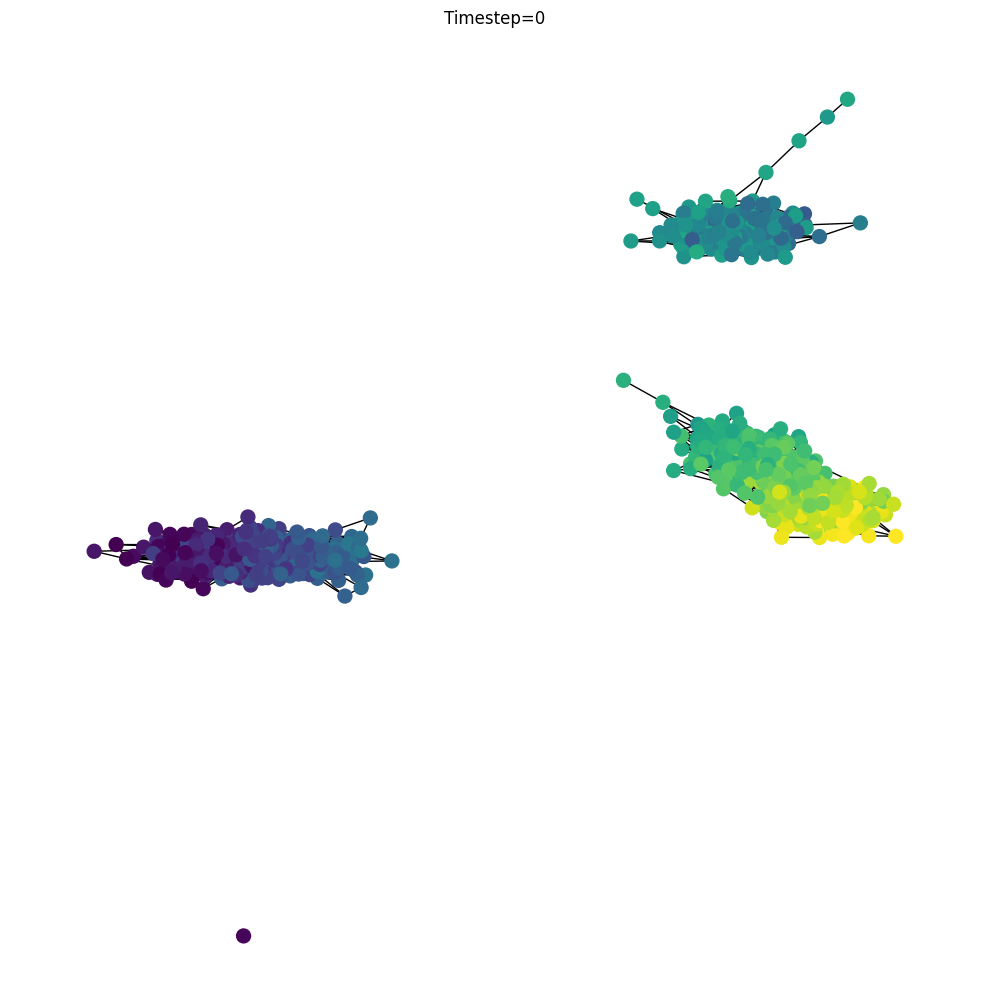

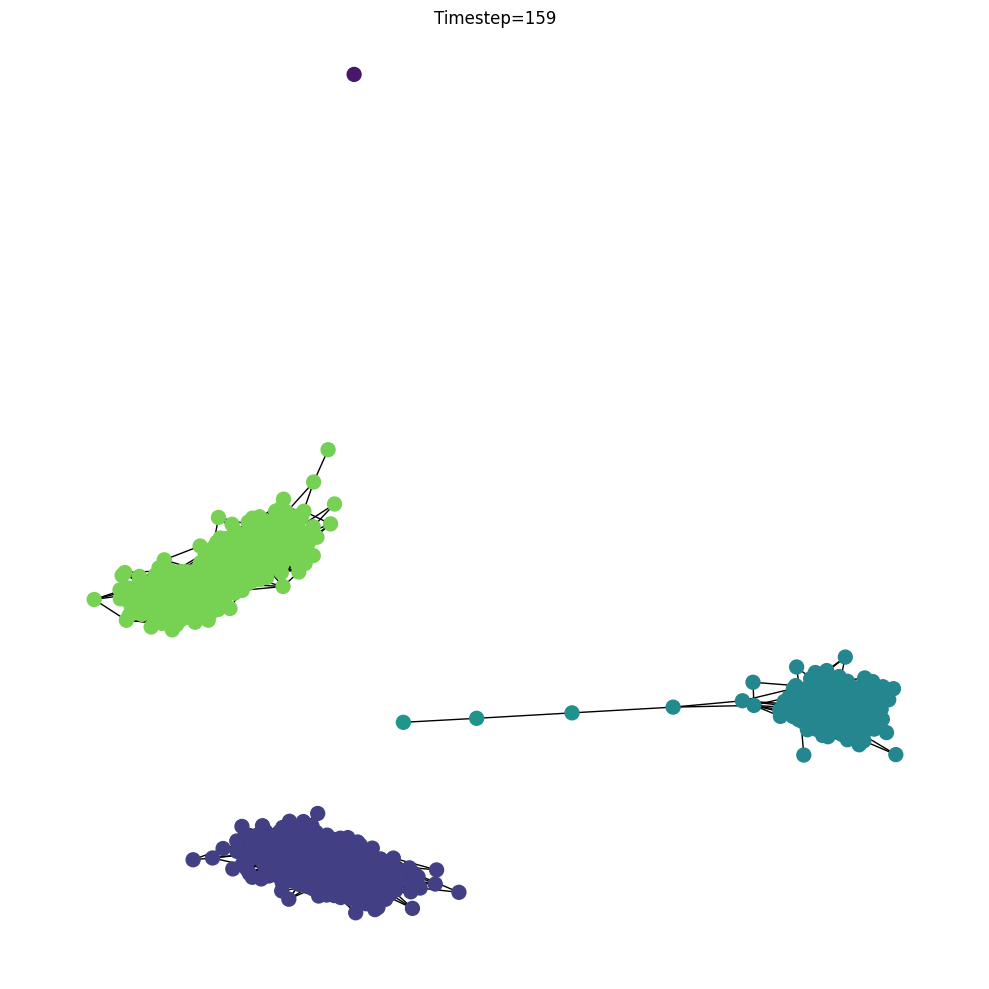

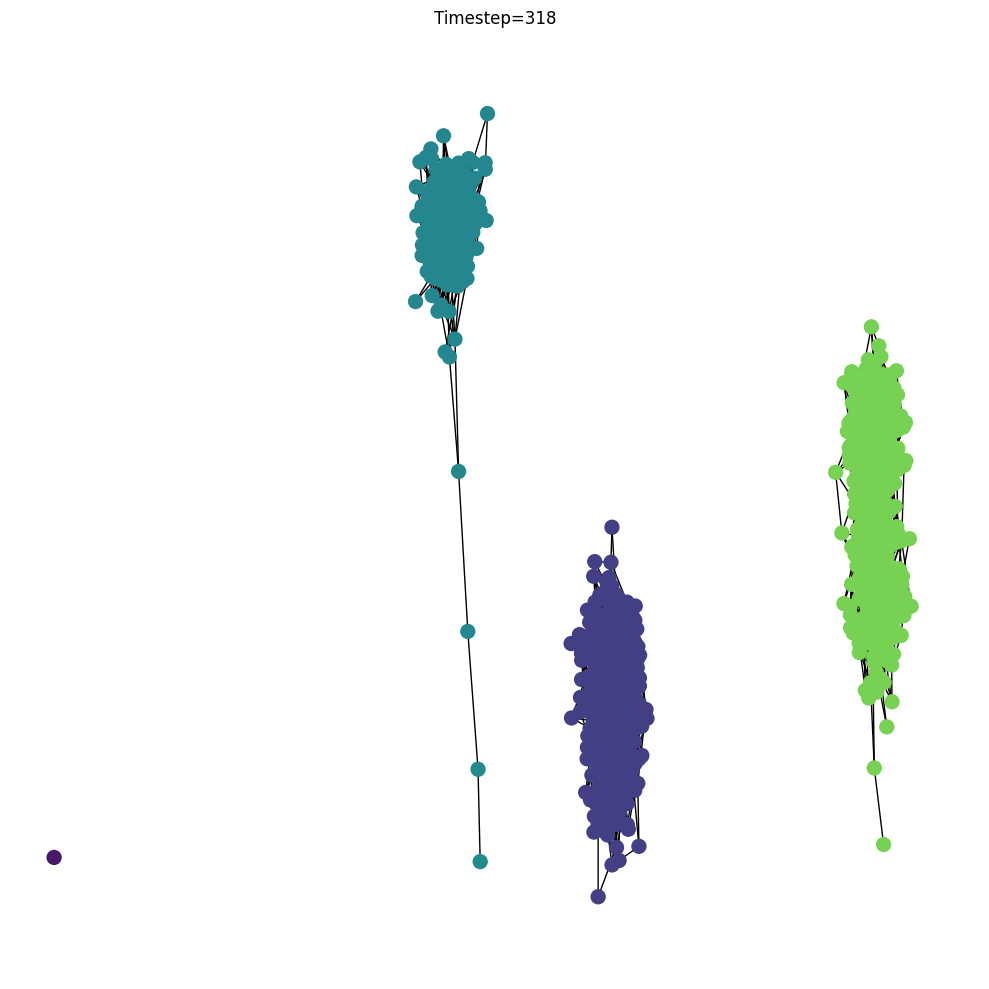

In [51]:
def plot_graph_snapshots(model: BoundedConfidenceModel, num_snapshots: int=3, *, seed=None, node_cmap='viridis', node_size=100, add_colorbar=False):
    X_data = model.X_data
    total_len = len(X_data)
    indices = np.linspace(0, total_len-1, num_snapshots, dtype=int)

    for timestep in indices:
        G, timestep = get_graph(model, timestep)
        node_ids = list(G.nodes())
        node_values = X_data[timestep, node_ids]

        pos = nx.spring_layout(G, seed=seed)
        fig, ax = plt.subplots(figsize=(10, 10))
        sc = nx.draw(
            G,
            pos,
            ax=ax,
            node_color=node_values,
            vmin=0,
            vmax=1,
            cmap=node_cmap,
            node_size=node_size,
            with_labels=False
        )
        ax.set_title(f"Timestep={timestep}")
        if add_colorbar:
            cbar = fig.colorbar(
                sc, ax=ax, shring=0.7, label="Opinion"
            )
        plt.tight_layout()

plot_graph_snapshots(data, num_snapshots=3)

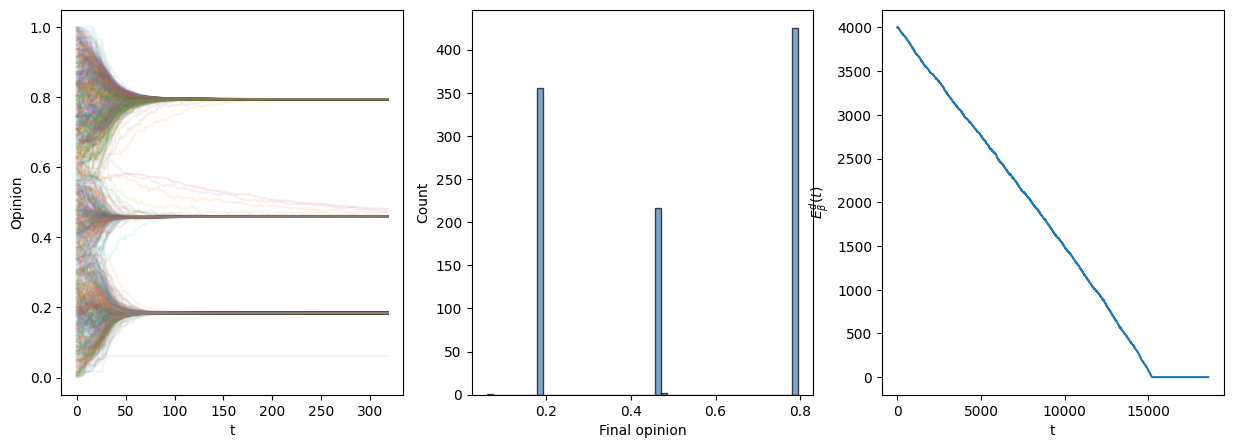

In [ ]:
def plot_time_evolution_of_opinions(
    model: BoundedConfidenceModel,
    ax: plt.Axes
):
    opinions = model.X_data
    ax.plot(opinions, alpha=0.1)
    ax.set_xlabel('t')
    ax.set_ylabel('Opinion')

def plot_distribution_of_opinions(
    model: BoundedConfidenceModel,
    ax: plt.Axes
):
    opinions = model.X_data[-1, :]
    ax.hist(opinions, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
    ax.set_xlabel('Final opinion')
    ax.set_ylabel('Count')

def plot_time_evoluton_of_discordant_edges(
    model: BoundedConfidenceModel,
    ax: plt.Axes
):
    edges = model.num_discordant_edges
    ax.plot(edges)
    ax.set_ylabel(r"$ E_{β}^{d} (t) $")
    ax.set_xlabel('t')

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
plot_time_evolution_of_opinions(data, axs[0])
plot_distribution_of_opinions(data, axs[1])
plot_time_evoluton_of_discordant_edges(data, axs[2])

In [10]:
model = BoundedConfidenceModel(
    C=0.1,
    beta=0.1,
    trial=1
)
model.run()

FileNotFoundError: [Errno 2] No such file or directory: 'data/C_010_beta_010_trial_1_spk_None.pbz2'

In [11]:
model.save_model()

In [13]:
import bz2

In [14]:
with bz2.open("./data/C_010_beta_010_trial_1_spk_None.pbz2") as f:
    data = cPickle.load(f)

In [18]:
data.X_data.shape

(319, 1000)

In [32]:
data.G_snapshots[0][1].nodes[1]

{}

In [25]:
np.trim_zeros(data.num_discordant_edges)

array([4.002e+03, 4.002e+03, 4.002e+03, ..., 1.000e+00, 1.000e+00,
       1.000e+00], shape=(18591,))